# FGSM Topology Analysis

**Goal:** Compute persistent homology for FGSM adversarial features and compare with clean topology

### Overview
In this notebook, we will:
1. Load FGSM adversarial features (50-dim PCA-reduced)
2. Compute persistence diagrams for H0 and H1
3. Compare clean vs FGSM topological signatures
4. Visualize differences in persistence diagrams and Betti curves
5. Extract and compare topological statistics

---

### Hypothesis
Adversarial perturbations should:
- **Fragment clusters** → More H0 features with higher persistence
- **Destroy loops** → Fewer H1 features with lower persistence
- **Increase topological distance** from clean manifold

### Setup and Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.feature_extractor import FeatureExtractor
from src.tda.persistence import (compute_persistence, save_diagrams, load_diagrams, get_persistence_stats, compute_betti_numbers)
from src.utils.plotting import (plot_persistence_diagram, plot_betti_curve, compare_persistence_diagrams, compare_betti_curves, plot_statistics_comparison)

np.random.seed(111)
print("Successfully imported everything")

Successfully imported everything


### Load FGSM Adversarial Features

These features were extracted from FGSM adversarial examples (ε=0.03) in `03_adversarial_attacks.ipynb`

In [2]:
data_fgsm = np.load('../results/features/fgsm_features_reduced.npz')       # FGSM features
fgsm_features = data_fgsm['features']
fgsm_labels = data_fgsm['labels']
epsilon = data_fgsm['epsilon']

print(f"FGSM features shape: {fgsm_features.shape}")
print(f"Feature range: [{fgsm_features.min():.4f}, {fgsm_features.max():.4f}]")
print(f"Attack epsilon: {epsilon}")

data_clean = np.load('../results/features/clean_features_reduced.npz')     # clean features for comparison
clean_features = data_clean['features']
clean_labels = data_clean['labels']

print(f"\nClean features shape: {clean_features.shape}")

FGSM features shape: (45000, 50)
Feature range: [-2.4430, 1.6134]
Attack epsilon: 0.03

Clean features shape: (45000, 50)


### Subsample for TDA

Let's use the same 10,000 samples as in the clean analysis for fair comparison:

In [3]:
n_samples = 10000
indices = np.random.choice(len(fgsm_features), n_samples, replace=False)
fgsm_features_subset = fgsm_features[indices]
fgsm_labels_subset = fgsm_labels[indices]

print(f"Using {n_samples} samples for TDA")
print(f"FGSM subset shape: {fgsm_features_subset.shape}")

Using 10000 samples for TDA
FGSM subset shape: (10000, 50)


### Compute Persistent Homology for FGSM Features

This will take a 1-2 minutes:

In [4]:
result_fgsm = compute_persistence(
    fgsm_features_subset,
    maxdim=1,
    verbose=True
)

print("\nPersistence computation successfully completed")

Computing persistence for 10000 points in 50D:
Persistence computed
H0 features: 10000
H1 features: 14962

Persistence computation successfully completed


### Extract FGSM Persistence Diagrams

In [6]:
fgsm_h0 = result_fgsm['dgms'][0]    # diagrams
fgsm_h1 = result_fgsm['dgms'][1]

print(f"FGSM H0 diagram: {len(fgsm_h0)} features")
print(f"FGSM H1 diagram: {len(fgsm_h1)} features")

# Stats:
print("\n--- FGSM H0 Statistics ---")
fgsm_h0_stats = get_persistence_stats(fgsm_h0)
print(f"Number of features: {fgsm_h0_stats['n_features']}")
print(f"Total persistence: {fgsm_h0_stats['total_persistence']:.4f}")
print(f"Mean persistence: {fgsm_h0_stats['mean_persistence']:.4f}")
print(f"Max persistence: {fgsm_h0_stats['max_persistence']:.4f}")

print("\n--- FGSM H1 Statistics ---")
fgsm_h1_stats = get_persistence_stats(fgsm_h1)
print(f"Number of features: {fgsm_h1_stats['n_features']}")
print(f"Total persistence: {fgsm_h1_stats['total_persistence']:.4f}")
print(f"Mean persistence: {fgsm_h1_stats['mean_persistence']:.4f}")
print(f"Max persistence: {fgsm_h1_stats['max_persistence']:.4f}")

FGSM H0 diagram: 10000 features
FGSM H1 diagram: 14962 features

--- FGSM H0 Statistics ---
Number of features: 9999
Total persistence: 2870.3901
Mean persistence: 0.2871
Max persistence: 1.1521

--- FGSM H1 Statistics ---
Number of features: 14962
Total persistence: 161.5743
Mean persistence: 0.0108
Max persistence: 0.0905


### Load Clean Persistence Diagrams for Comparison

Let's load the clean diagrams we computed in `04_tda_analysis.ipynb`:

In [7]:
result_clean = load_diagrams('../results/diagrams/clean_full.pkl')
clean_h0 = result_clean['dgms'][0]
clean_h1 = result_clean['dgms'][1]

# Stats:
print("--- Clean H0 Statistics ---")
clean_h0_stats = get_persistence_stats(clean_h0)
print(f"Number of features: {clean_h0_stats['n_features']}")
print(f"Total persistence: {clean_h0_stats['total_persistence']:.4f}")
print(f"Mean persistence: {clean_h0_stats['mean_persistence']:.4f}")
print(f"Max persistence: {clean_h0_stats['max_persistence']:.4f}")

print("\n--- Clean H1 Statistics ---")
clean_h1_stats = get_persistence_stats(clean_h1)
print(f"Number of features: {clean_h1_stats['n_features']}")
print(f"Total persistence: {clean_h1_stats['total_persistence']:.4f}")
print(f"Mean persistence: {clean_h1_stats['mean_persistence']:.4f}")
print(f"Max persistence: {clean_h1_stats['max_persistence']:.4f}")

Loaded diagrams from ../results/diagrams/clean_full.pkl
--- Clean H0 Statistics ---
Number of features: 9999
Total persistence: 2831.9765
Mean persistence: 0.2832
Max persistence: 1.1873

--- Clean H1 Statistics ---
Number of features: 14978
Total persistence: 161.5036
Mean persistence: 0.0108
Max persistence: 0.0976


### Compare H0 Persistence Diagrams (Side by Side)

Let's visualize how adversarial perturbations affect cluster structure:

Saved to ../results/figures/05_compare_h0_diagrams.png


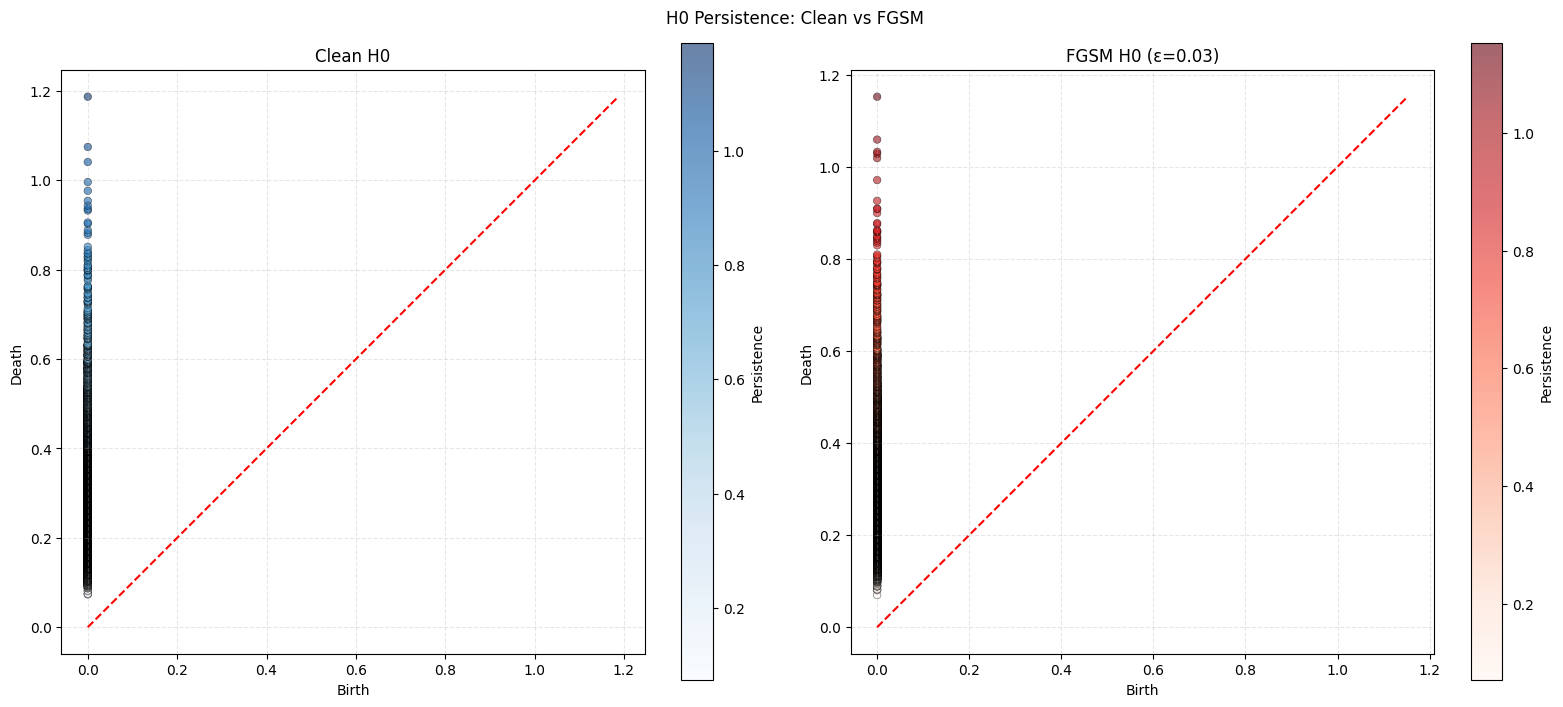

In [8]:
compare_persistence_diagrams(
    clean_h0,
    fgsm_h0,
    label1="Clean H0",
    label2=f"FGSM H0 (ε={epsilon})",
    title="H0 Persistence: Clean vs FGSM",
    save_path="../results/figures/05_compare_h0_diagrams.png"
)

### Compare H1 Persistence Diagrams

Now let's find out how do adversarial perturbations affect loops/cycles?

Saved to ../results/figures/05_compare_h1_diagrams.png


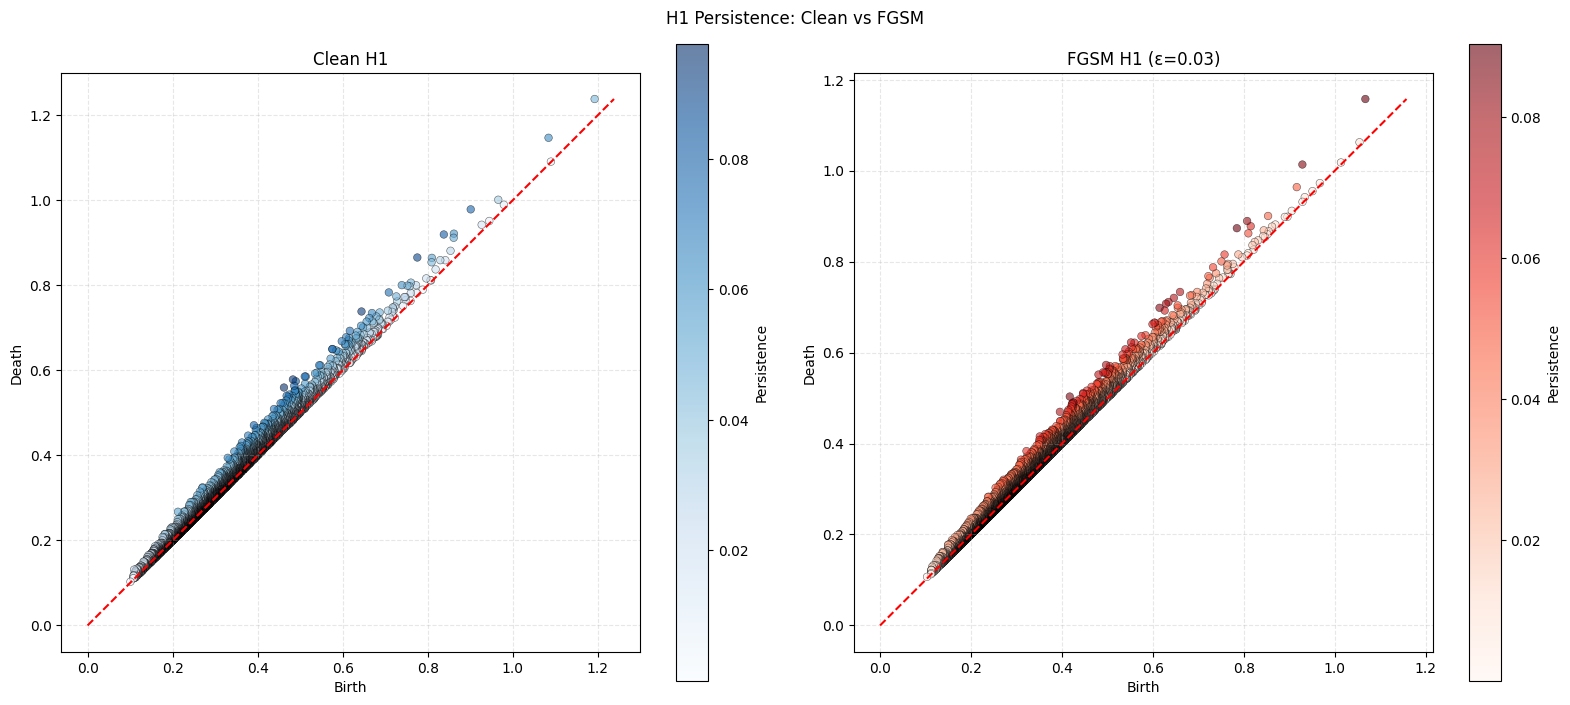

In [9]:
compare_persistence_diagrams(
    clean_h1,
    fgsm_h1,
    label1="Clean H1",
    label2=f"FGSM H1 (ε={epsilon})",
    title="H1 Persistence: Clean vs FGSM",
    save_path="../results/figures/05_compare_h1_diagrams.png"
)

### Compute and Compare Betti Curves

Remmeber that Betti curves show how many features are alive at each scale.

In [10]:
# Betti curves for FGSM
epsilons_fgsm_h0, betti_fgsm_h0 = compute_betti_numbers(fgsm_h0)
epsilons_fgsm_h1, betti_fgsm_h1 = compute_betti_numbers(fgsm_h1)

# Betti curves for clean (if not already done)
epsilons_clean_h0, betti_clean_h0 = compute_betti_numbers(clean_h0)
epsilons_clean_h1, betti_clean_h1 = compute_betti_numbers(clean_h1)

Saved to ../results/figures/05_compare_h0_betti.png


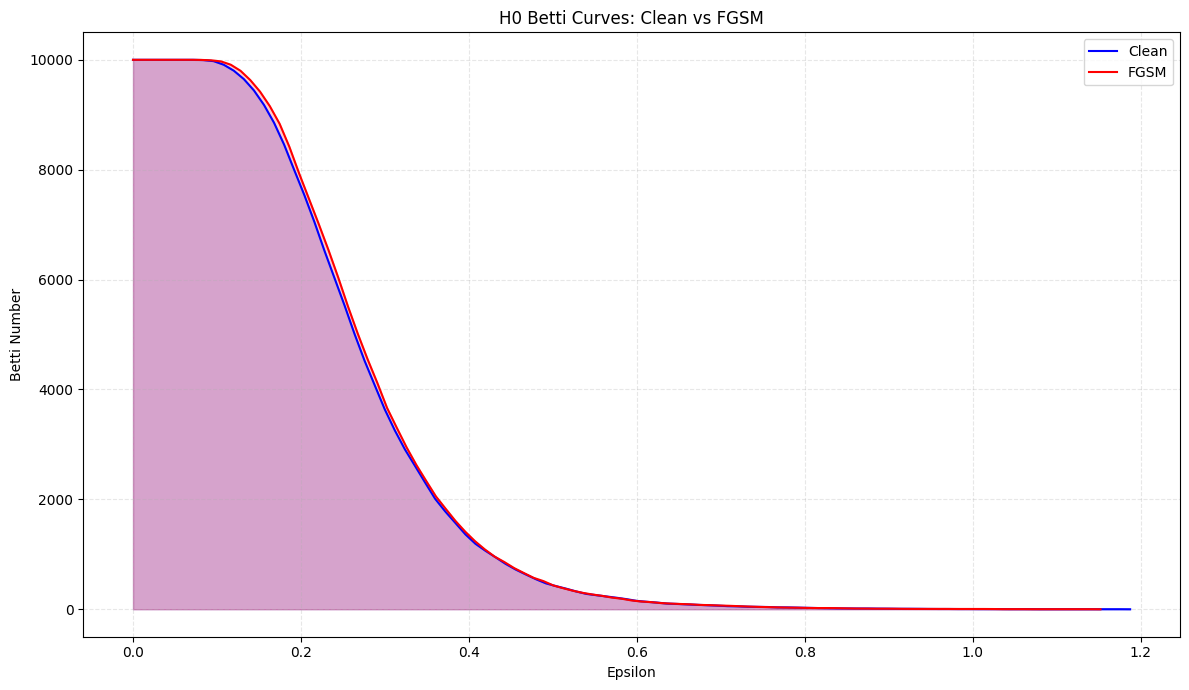

In [11]:
# Compare H0 Betti curves:

compare_betti_curves(
    epsilons_clean_h0,
    betti_clean_h0,
    epsilons_fgsm_h0,
    betti_fgsm_h0,
    label1="Clean",
    label2="FGSM",
    title="H0 Betti Curves: Clean vs FGSM",
    save_path="../results/figures/05_compare_h0_betti.png"
)

Saved to ../results/figures/05_compare_h1_betti.png


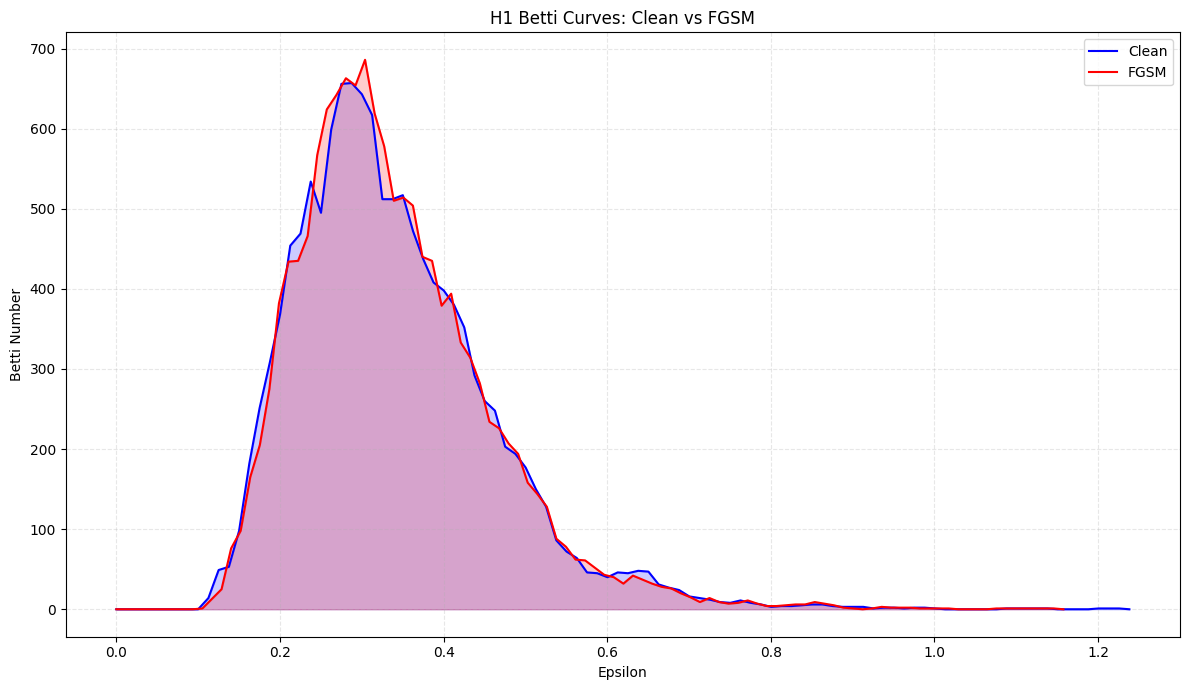

In [12]:
# Compare H1 Betti curves:

compare_betti_curves(
    epsilons_clean_h1,
    betti_clean_h1,
    epsilons_fgsm_h1,
    betti_fgsm_h1,
    label1="Clean",
    label2="FGSM",
    title="H1 Betti Curves: Clean vs FGSM",
    save_path="../results/figures/05_compare_h1_betti.png"
)